In [1]:
import os
import matplotlib.pyplot as plt
from collections import Counter
from PIL import Image
import seaborn as sns

# Cấu hình đường dẫn dataset
dataset_path = "/media/icnlab/Data/Manh/tinyML/FieldPlant-11/train"

# # Bước 1: Đọc thông tin các lớp và ảnh Plantdoc
# class_names = sorted(os.listdir(dataset_path))
# class_names = [cls for cls in class_names if os.path.isdir(os.path.join(dataset_path, cls))]

# # read tomato class
# tomato_classes = [cls for cls in tomato_classes if os.path.isdir(os.path.join(dataset_path, cls)) & ('tomato' in cls.lower())]

# for cls in tomato_classes:
#     class_folder = os.path.join(dataset_path, cls)
#     for fname in os.listdir(class_folder):
#         if fname.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tiff')):
#             image_paths.append(os.path.join(class_folder, fname))
#             labels.append(cls)

# Đọc thông tin FieldPlant
file = '/media/icnlab/Data/Manh/tinyML/FieldPlant-11/train/_annotations.coco.json'
from pycocotools.coco import COCO
coco = COCO(file)
cats = coco.loadCats(coco.getCatIds())

def get_category_info(id):
    # Get all categories
    cats = coco.loadCats(coco.getCatIds())
    
    for cat in cats:
        if cat['id'] == id:
            return {
                'id': cat['id'],
                'name': cat['name'],
                'supercategory': cat['supercategory'],
            }
    return None

len(os.listdir(dataset_path))

loading annotations into memory...
Done (t=0.94s)
creating index...
index created!


5157

In [7]:
%store -r labels image_paths

from collections import Counter
class_count = Counter(labels)
class_names = list(class_count.keys())

len(labels), len(image_paths), len(class_names)


(2786, 2786, 6)

📦 Tổng số ảnh: 2786
🔖 Số lớp: 6
📚 Danh sách lớp: ['Tomato Brown Spots', 'Tomato healthy', 'Tomato blight leaf', 'Tomato leaf mosaic virus', 'Tomato leaf yellow virus', 'Tomato bacterial wilt']


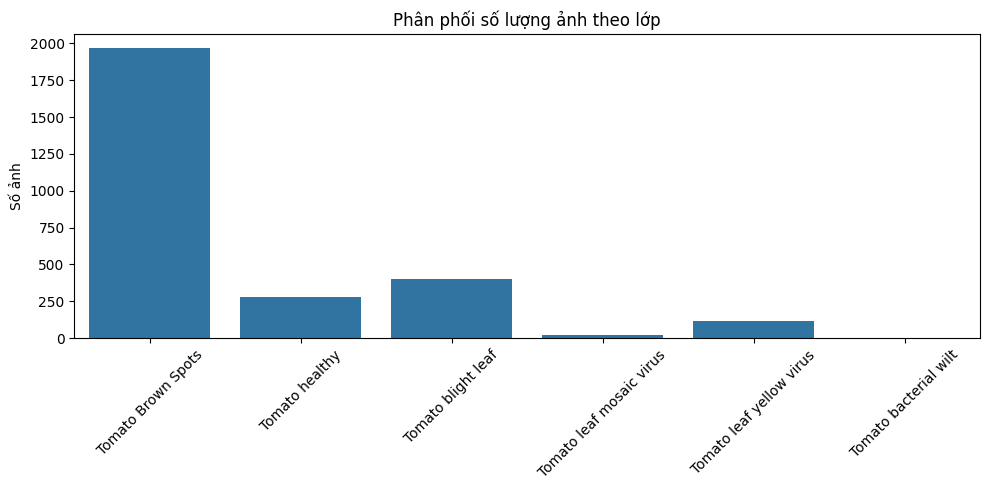

In [12]:
# Bước 2: Thống kê tổng quan
print(f"📦 Tổng số ảnh: {len(image_paths)}")
print(f"🔖 Số lớp: {len(class_names)}")
print(f"📚 Danh sách lớp: {class_names}")

# Bước 3: Vẽ biểu đồ phân phối số ảnh theo lớp
label_counts = Counter(labels)
plt.figure(figsize=(10, 5))
sns.barplot(x=list(label_counts.keys()), y=list(label_counts.values()))
plt.title("Phân phối số lượng ảnh theo lớp")
plt.xticks(rotation=45)
plt.ylabel("Số ảnh")
plt.tight_layout()
plt.show()

# Bước 4: Hiển thị ảnh ví dụ
def show_sample_images(image_paths, labels, class_names, samples_per_class=3):
    plt.figure(figsize=(samples_per_class * 3, len(class_names) * 3))
    for class_idx, class_name in enumerate(class_names):
        class_images = [p for p, l in zip(image_paths, labels) if l == class_name][:samples_per_class]
        for i, img_path in enumerate(class_images):
            plt_idx = class_idx * samples_per_class + i + 1
            img = Image.open(img_path)
            plt.subplot(len(class_names), samples_per_class, plt_idx)
            plt.imshow(img)
            plt.axis('off')
            if i == 0:
                plt.ylabel(class_name, rotation=0, labelpad=60, fontsize=12)
    plt.suptitle("Một vài ảnh ví dụ từ mỗi lớp", fontsize=16)
    plt.tight_layout()
    plt.show()

# show_sample_images(image_paths, labels, class_names)

Phân tích ảnh: 100%|██████████| 2786/2786 [00:37<00:00, 73.52it/s]


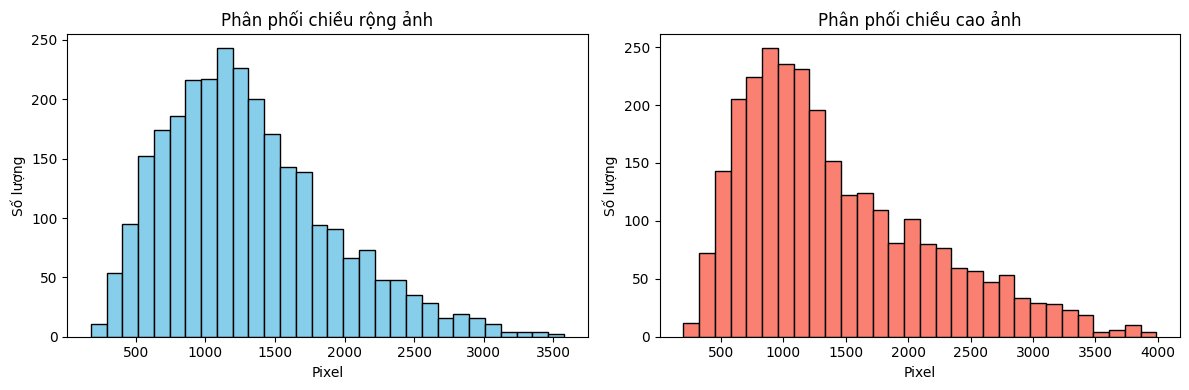

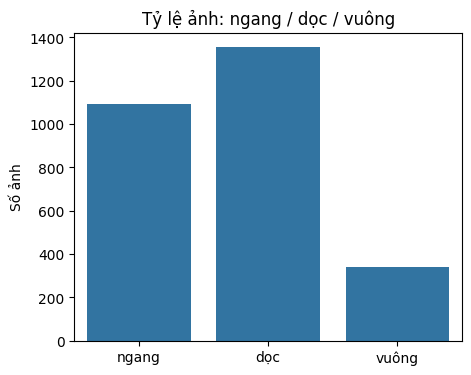

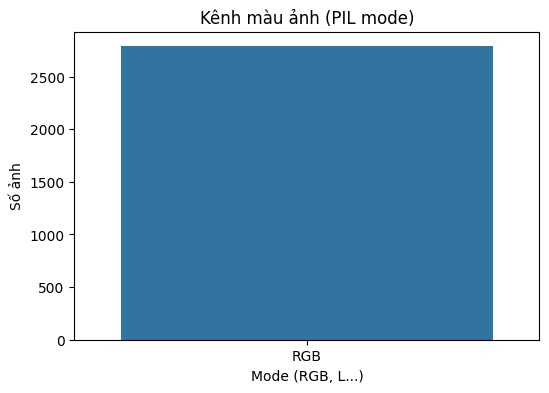

In [13]:
# Analyst image size
from tqdm import tqdm
import numpy as np

# Bước 5: Phân tích kích thước ảnh và tỷ lệ
widths, heights, modes = [], [], []
bad_files = 0

for path in tqdm(image_paths, desc="Phân tích ảnh"):
    try:
        with Image.open(path) as img:
            widths.append(img.width)
            heights.append(img.height)
            modes.append(img.mode)
    except Exception as e:
        bad_files += 1
        continue

# Kích thước ảnh phổ biến
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.hist(widths, bins=30, color='skyblue', edgecolor='black')
plt.title("Phân phối chiều rộng ảnh")
plt.xlabel("Pixel")
plt.ylabel("Số lượng")

plt.subplot(1, 2, 2)
plt.hist(heights, bins=30, color='salmon', edgecolor='black')
plt.title("Phân phối chiều cao ảnh")
plt.xlabel("Pixel")
plt.ylabel("Số lượng")

plt.tight_layout()
plt.show()

# Tỷ lệ ảnh: ngang, dọc, vuông
ratios = np.array(widths) / np.array(heights)
ratio_categories = ["ngang" if r > 1.1 else "dọc" if r < 0.9 else "vuông" for r in ratios]
ratio_counts = Counter(ratio_categories)

plt.figure(figsize=(5, 4))
sns.barplot(x=list(ratio_counts.keys()), y=list(ratio_counts.values()))
plt.title("Tỷ lệ ảnh: ngang / dọc / vuông")
plt.ylabel("Số ảnh")
plt.show()

# Bước 6: Phân tích kênh màu (mode: RGB, L, v.v.)
mode_counts = Counter(modes)
plt.figure(figsize=(6, 4))
sns.barplot(x=list(mode_counts.keys()), y=list(mode_counts.values()))
plt.title("Kênh màu ảnh (PIL mode)")
plt.xlabel("Mode (RGB, L...)")
plt.ylabel("Số ảnh")
plt.show()

# Báo cáo số ảnh lỗi
if bad_files > 0:
    print(f"⚠️ Có {bad_files} ảnh không thể mở được (có thể bị hỏng).")

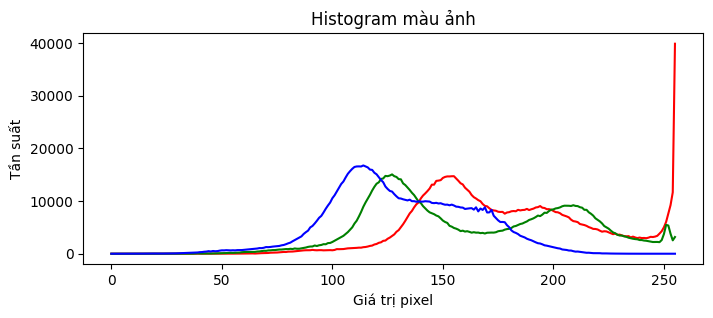

In [14]:
# Analyst histogram 1 image
def plot_color_histogram(image_path):
    img = Image.open(image_path).convert("RGB")
    channels = img.split()
    colors = ['red', 'green', 'blue']

    plt.figure(figsize=(8, 3))
    for channel, color in zip(channels, colors):
        hist = channel.histogram()
        plt.plot(hist, color=color)
    plt.title("Histogram màu ảnh")
    plt.xlabel("Giá trị pixel")
    plt.ylabel("Tần suất")
    plt.show()

plot_color_histogram(image_paths[0])

Tính độ sáng / tương phản: 100%|██████████| 500/500 [00:12<00:00, 38.87it/s]


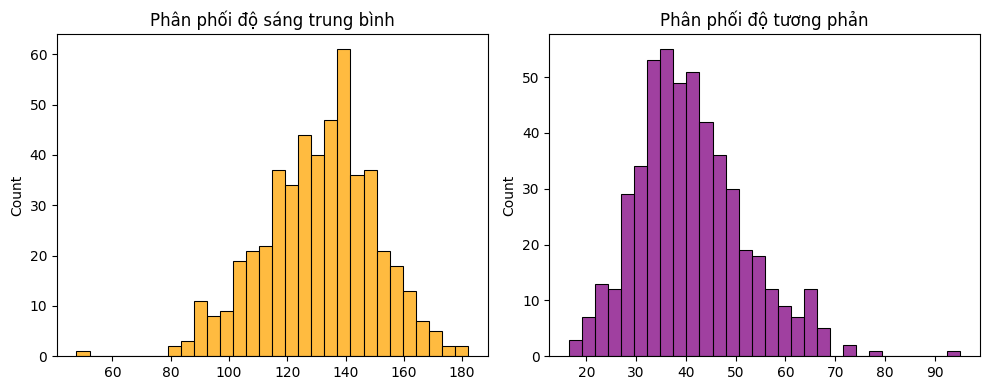

In [15]:
# Analyst 
def compute_brightness_contrast(img):
    grayscale = img.convert("L")
    arr = np.array(grayscale)
    brightness = arr.mean()
    contrast = arr.std()
    return brightness, contrast

brightness_list, contrast_list = [], []
for path in tqdm(image_paths[:500], desc="Tính độ sáng / tương phản"):  # giới hạn 500 ảnh cho nhanh
    try:
        img = Image.open(path)
        b, c = compute_brightness_contrast(img)
        brightness_list.append(b)
        contrast_list.append(c)
    except:
        continue

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
sns.histplot(brightness_list, bins=30, color="orange")
plt.title("Phân phối độ sáng trung bình")

plt.subplot(1, 2, 2)
sns.histplot(contrast_list, bins=30, color="purple")
plt.title("Phân phối độ tương phản")
plt.tight_layout()
plt.show()


In [16]:
import imagehash

hashes_phash = {}
duplicates_phash = []

for path in tqdm(image_paths, desc="pHash ảnh"):
    try:
        img = Image.open(path)
        h = imagehash.phash(img)
        if h in hashes_phash:
            duplicates_phash.append((hashes_phash[h], path))
        else:
            hashes_phash[h] = path
    except:
        continue

print(f"🔍 Số ảnh trùng theo pHash: {len(duplicates_phash)}")

pHash ảnh: 100%|██████████| 2786/2786 [01:05<00:00, 42.63it/s]

🔍 Số ảnh trùng theo pHash: 4


📊 Tỉ lệ mất cân bằng: lớn nhất / nhỏ nhất = 1967 / 2 = 983.50


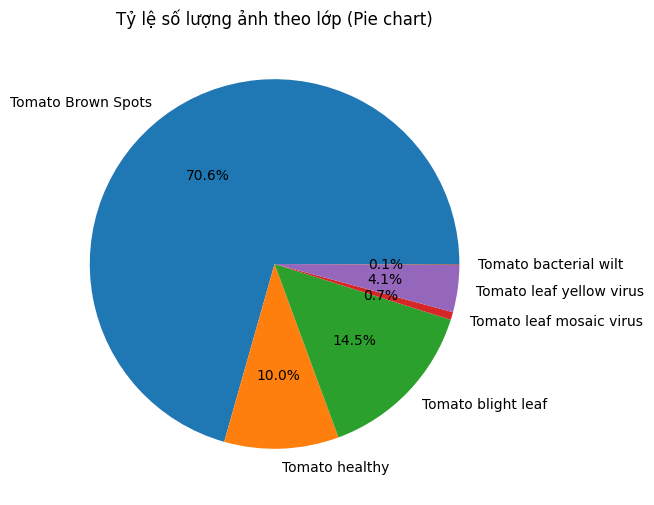

In [18]:
# check class imbalance
max_class = max(label_counts.values())
min_class = min(label_counts.values())
print(f"📊 Tỉ lệ mất cân bằng: lớn nhất / nhỏ nhất = {max_class} / {min_class} = {max_class / min_class:.2f}")

plt.figure(figsize=(6, 6))
plt.pie(label_counts.values(), labels=label_counts.keys(), autopct='%1.1f%%')
plt.title("Tỷ lệ số lượng ảnh theo lớp (Pie chart)")
plt.show()